In [3]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
# Imports

import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



In [2]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [4]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Stable Entropy Baselines

In [23]:
NUM_SEQ=2000
MAX_LEN=100
WIDTH=5
MAX_SOURCE_LEN=1024


## Text Completion

In [6]:
# Text Completion data
wikipedia_text_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl"
writing_prompt_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/orig.jsonl"
cc_news = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/cc_news/generated/orig.jsonl"
pg19_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/pg19_rankgen/generated/orig.jsonl"
# Summarization

In [8]:
# GPT-2 XL Model
from transformers import AutoTokenizer, AutoModelForCausalLM
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2-xl")
gpt2_model = gpt2_model.to('cuda')

In [ ]:
# Load GPT2 model fine-tuned on writing prompts

# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-14-2022-11-03/checkpoint-71000/"
gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-18-2022-05-33-01/checkpoint-55000/"
# gpt2_writing_prompt_modelfile = 'gpt2-large'
model_args = ModelArguments(
    model_name_or_path=gpt2_writing_prompt_modelfile,   
)
fine_tuned_gpt2_model = get_model(model_args)
fine_tuned_gpt2_model.to('cuda')
fine_tuned_tokenizer = get_tokenizer(model_args)
fine_tuned_tokenizer.pad_token = fine_tuned_tokenizer.eos_token
fine_tuned_gpt2_model = gpt2_model.to('cuda')

# compute_metrics = get_compute_metrics_func(experiment_id="jupyter_ipynb", metric_names=['accuracy', 'mauve'])

In [9]:
wikipedia_dataframe = pd.read_json(wikipedia_text_completion, lines=True)
writing_prompt_dataframe = pd.read_json(writing_prompt_completion, lines=True)
cc_news_dataframe = pd.read_json(cc_news, lines=True)
pg19_dataframe = pd.read_json(pg19_completion, lines=True)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


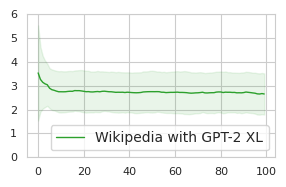

In [24]:
# Wikipedia and GPT-2 XL
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right",)
ax.tick_params(labelsize=8)


In [ ]:
# Writing Prompts and GPT-2 XL
dataframe, dataset_name = (writing_prompt_dataframe, "Writing Prompts")
model,tokenizer,model_name = (fine_tuned_gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=8, loc="lower right")
ax.tick_params(labelsize=8)


Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


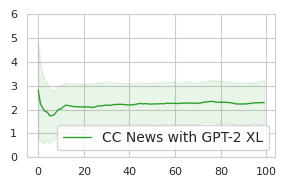

In [25]:
# CC News and GPT-2 XL
dataframe, dataset_name = (cc_news_dataframe, "CC News")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


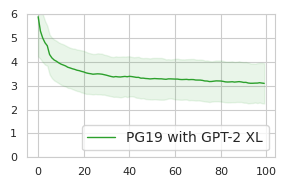

In [26]:
# PG19 and GPT-2 XL
dataframe, dataset_name = (pg19_dataframe, "PG19")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

In [27]:
from transformers import AutoTokenizer, AutoModelForCausalLM
opt_tokenizer = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
opt_model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")
opt_model = opt_model.to("cuda")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


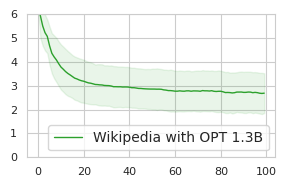

In [28]:
# Wikipedia and OPT
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right",)
ax.tick_params(labelsize=8)

In [29]:
# Writing Prompts and OPT
dataframe, dataset_name = (writing_prompt_dataframe, "Writing Prompts")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

KeyboardInterrupt: 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


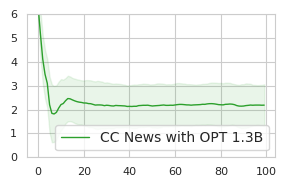

In [30]:
# CC News and OPT
dataframe, dataset_name = (cc_news_dataframe, "CC News")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10,loc="lower right")
ax.tick_params(labelsize=8)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


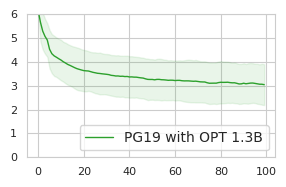

In [31]:
# PG19 and GPT-2 XL
dataframe, dataset_name = (pg19_dataframe, "PG19")
model,tokenizer,model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, human_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(human_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

## Summarization

In [32]:
# Load Pegasus fine-tuned on cnn_dailymail
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

pegasusxl_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

pegasusxl_model = pegasusxl_model.to('cuda')
pegasusxl_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")


In [33]:
cnn_dm_data='/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/orig.jsonl'
cnn_dm_dataframe = pd.read_json(cnn_dm_data, lines=True)\
                        .rename(columns={'document':'context', 
                                         'summary': 'model_text'})

In [34]:
_, cnn_entropies = compute_average_across_sequences(cnn_dm_dataframe, pegasusxl_model, pegasusxl_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-4a5985cbc3ce861a1fbc1d173cd0f018-human_generated-100-2000-entropy_ma-5-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-4a5985cbc3ce861a1fbc1d173cd0f018-human_generated-100-2000-entropy_ma-5-1024-avgs.csv


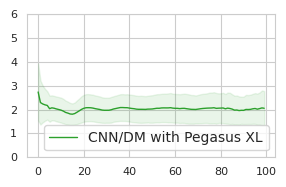

In [52]:
# CNN/DM and PegasusXL
dataset_name = "CNN/DM"
model_name = "Pegasus XL"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cnn_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

In [36]:
## BART

In [37]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
bart_model = bart_model.to("cuda")

In [38]:
_, cnn_bart_entropies = compute_average_across_sequences(cnn_dm_dataframe, bart_model, bart_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-100-2000-entropy_ma-5-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-100-2000-entropy_ma-5-1024-avgs.csv


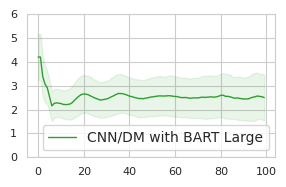

In [51]:
# CNN/DM and BART
dataset_name = "CNN/DM"
model_name = "BART Large"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cnn_bart_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

## Dialog

In [40]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

bb_tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-1B-distill")

bb_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/blenderbot-1B-distill")
bb_model = bb_model.to("cuda")

In [41]:
bst_data='/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/orig.jsonl'
bst_dataframe = pd.read_json(bst_data, lines=True)
MAX_SOURCE_LEN=128
MAX_LEN=40
NUM_SEQ=10000

In [42]:
bsts, bst_entropies = compute_average_across_sequences(bst_dataframe, bb_model, bb_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/4f48a77b7fbdf72ca3cd7937f7514b07-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-10000-entropy_ma-5-128-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/4f48a77b7fbdf72ca3cd7937f7514b07-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-10000-entropy_ma-5-128-avgs.csv


In [43]:
import numpy as np
arr=np.load('/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/2f6d20a0018f307bac43472b608139b0-eb7a18a7c936b032102d589950efd6c2-human_generated-60-5000-entropy_ma-5-128-ndarray.npy')

In [50]:
counts, bins = np.histogram(np.sort((arr > -1).sum(axis=1)), bins=20)

In [45]:
[(x,y) for x,y in zip(counts.tolist(), bins.tolist())]

[(203, 12.0),
 (471, 14.2),
 (588, 16.4),
 (608, 18.6),
 (582, 20.8),
 (739, 23.0),
 (432, 25.200000000000003),
 (351, 27.400000000000002),
 (284, 29.6),
 (270, 31.8),
 (264, 34.0),
 (103, 36.2),
 (56, 38.400000000000006),
 (21, 40.6),
 (12, 42.800000000000004),
 (11, 45.0),
 (2, 47.2),
 (0, 49.400000000000006),
 (1, 51.6),
 (2, 53.800000000000004)]

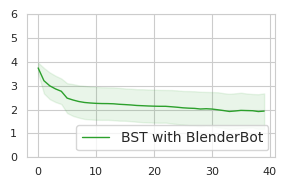

In [46]:
# Empathetic Dialog and BB1
dataset_name = "BST"
model_name = "BlenderBot"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(bst_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=10, loc="lower right")
ax.tick_params(labelsize=8)

# Correlation Plots

In [47]:
correlation_data = pd.read_csv('/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/compiled_results.csv', index_col=0)
correlation_data['Decoding Method'] = correlation_data['dataset'].str.extract("(top_k|temp|top_p|typical|eags|beam|greedy)")
correlation_data['Decoding Method'].str.replace("eags", "temperature")
correlation_data['Decoding Method'].str.replace("temp", "temperature")
correlation_data

,repeat_score@5,ngram_repeat@3,f1_score,dataset,entropy_violation_ratio,upper_bound_violation_ratio,lower_bound_violation_ratio,mauve,Decoding Method
0,0.515100,1.004910,0.067298,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1...,0.188697,0.144597,0.044100,0.511147,temp
1,0.700590,2.524834,0.087580,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.145786,0.084740,0.061046,0.673917,typical
2,2.012528,29.243842,0.093067,data/wiki_rankgen/corr_analysis/gpt2_xl/top_p_...,0.321999,0.071408,0.250591,0.340562,top_p
3,0.788305,3.412989,0.094096,data/wiki_rankgen/corr_analysis/gpt2_xl/top_p_...,0.154785,0.082230,0.072556,0.693837,top_p
4,1.195263,10.222398,0.101973,data/wiki_rankgen/corr_analysis/gpt2_xl/top_p_...,0.201448,0.078333,0.123115,0.586760,top_p
...,...,...,...,...,...,...,...,...,...
97,0.287665,0.192400,0.035921,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1...,0.389991,0.369939,0.020052,0.125599,temp
98,0.612968,1.667241,0.082775,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.151154,0.095229,0.055925,0.648113,typical
99,0.566724,1.341948,0.074501,data/wiki_rankgen/corr_analysis/gpt2_xl/top_p_...,0.162538,0.114061,0.048477,0.580518,top_p
100,0.569925,1.373358,0.076592,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.157281,0.105848,0.051433,0.595997,typical


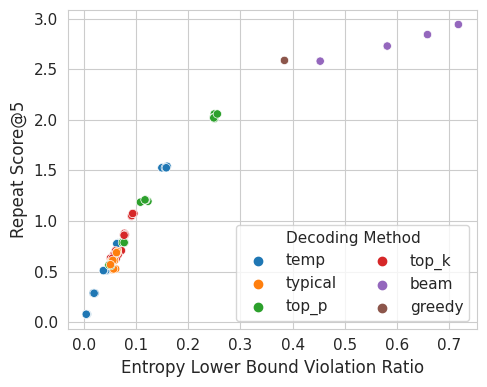

In [48]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='lower_bound_violation_ratio', y='repeat_score@5', ax=ax, hue='Decoding Method')
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
ax.set_ylabel("Repeat Score@5")
sns.move_legend(ax, loc="lower right", ncol=2)


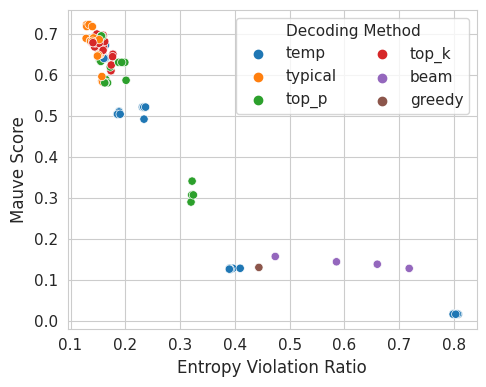

In [49]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='entropy_violation_ratio', y='mauve', ax=ax, hue='Decoding Method')
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Violation Ratio")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper right", ncol=2)